# Arabidopsis Multi-Plant Tutorial

This is a fully-functioning workflow that demonstrates how to analyze the shape, size, and color of individual arabidopsis plants grown in a tray. Similar methods will work for other plant species imaged in this layout until the plants grow large enough to obscure each other.


# Section 1: Importing Image and Libraries

In [1]:
%pip install "altair>=5" ipympl  plantcv
from google.colab import drive
drive.mount('/content/gdrive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.5/471.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
  Attempting uninstall: altair
    F

KeyboardInterrupt: ignored

In [1]:
# Set the notebook display method
%matplotlib inline

In [2]:
# Import libraries
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs
# Change working directory to point to Google Drive folder where notebook is stored.
%cd '/content/gdrive/MyDrive/Colab Notebooks/20230828-UFMG-PlantCV-Workshop/Image-Analysis-using-PlantCV/Multiple-Plant-Analysis'
!ls

/content/gdrive/.shortcut-targets-by-id/1LV2620sF2ER0ciOg917LLdTzmTK5D3EY/20230828-UFMG-PlantCV-Workshop/Image-Analysis-using-PlantCV/Multiple-Plant-Analysis
arabidopsis_results
arabidopsis_tray.jpg
plantcv-tutorial-arabidopsis-tray_reference.html
plantcv-tutorial-arabidopsis-tray_reference.ipynb
START-HERE_plantcv-tutorial-arabidopsis-tray.html
START-HERE_plantcv-tutorial-arabidopsis-tray.ipynb


## Input/Ouput variables

Using this while developing a workflow in Jupyter makes it easier to convert the workflow to a script later.

In [3]:
# Input/output options
args = WorkflowInputs(
    images=["./arabidopsis_tray.jpg"],
    names="image1",
    result="arabidopsis_results",
    outdir=".",
    writeimg=True,
    debug="plot",
    sample_label="genotype"
    )


In [4]:
# Set debug to the global parameter
pcv.params.debug = args.debug

# Set plotting size (default = 100)
pcv.params.dpi = 100

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20

## Read the input image

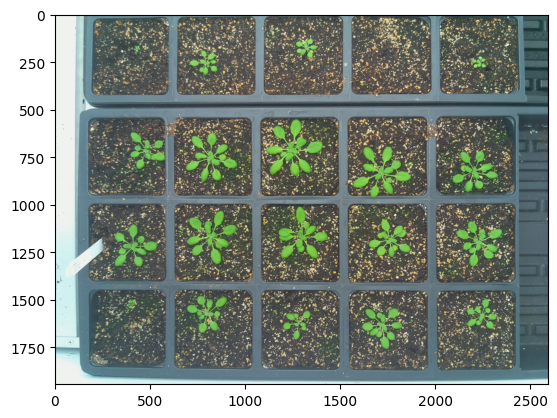

In [5]:
# Inputs:
#   filename = Image file to be read in
#   mode     = How to read in the image; either 'native' (default),
#              'rgb', 'gray', 'csv', or 'envi'
img, path, filename = pcv.readimage(filename=args.image1)

# Section 2: Segmenting plant from background and identifying plant object(s)


## Visualize colorspaces

The visualization tool converts the color image into HSV and LAB colorspaces
and displays the grayscale channels in a matrix so that they can be
visualized simultaneously. The idea is to select a channel that maximizes
the difference between the plant and the background pixels.

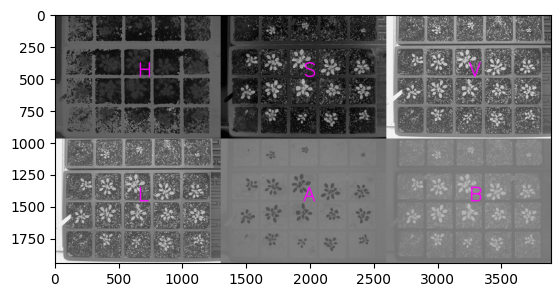

In [6]:
# Inputs:
#   rbg_img = original image
#   original_img = whether to includ the RGB image in the display:
#                  True (default) or False
colorspaces = pcv.visualize.colorspaces(rgb_img=img, original_img=False)

## Convert the color image to grayscale

Converts the input color image into the LAB colorspace
and returns the A (green-magenta) channel as a grayscale
image.

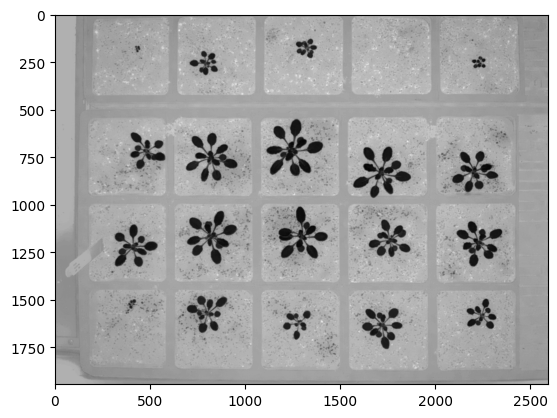

In [7]:
# Inputs:
#   rbg_img = original image
#   channel = desired colorspace ('l', 'a', or 'b')
a = pcv.rgb2gray_lab(rgb_img=img, channel='a')

## Visualize the distribution of grayscale values

A histogram can be used to visualize the distribution of values
in an image. The histogram can aid in the selection of a
threshold value. This is NOT helpful in parallel, only while building a workflow.

For this image, the large peak between 100-140 are from the
brighter background pixels. The smaller peak between 80-90
are the darker plant pixels.

In [8]:
hist = pcv.visualize.histogram(img=a, bins=25)

alt.Chart(...)

## Threshold the grayscale image

Use a threshold function (binary in this case) to segment the grayscale
image into plant (white) and background (black) pixels. Using the
histogram above, a threshold point between 90-110 will segment the
plant and background peaks. Because the plants are the darker pixels
in this image, use `object_type="dark"` to do an inverse threshold.

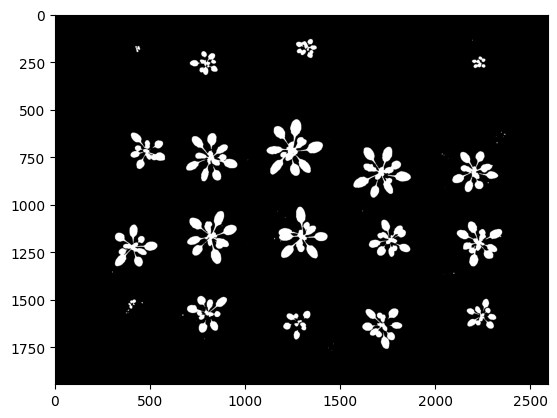

In [9]:
a_thresh = pcv.threshold.binary(gray_img=a, threshold=100, object_type='dark')

## Remove small background noise

Thresholding mostly labeled plant pixels white but also labeled
small regions of the background white. The fill function removes
"salt" noise from the background by filtering white regions by size.

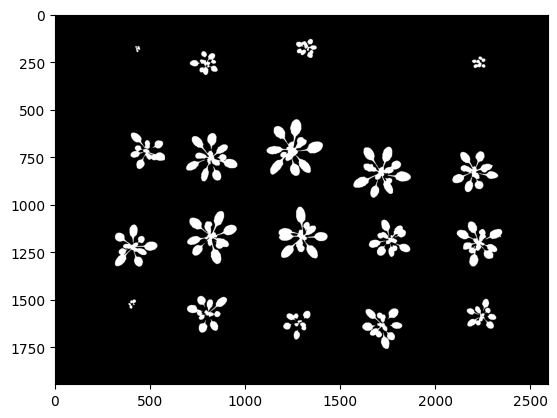

In [10]:
a_fill = pcv.fill(bin_img=a_thresh, size=200)

# Section 3: Define a region of interest for each plant

Use the automatic grid detection tool to define a region of interest (ROI) for each pot
in the tray. Each ROI will be associated with a plant later. The ROIs
do not need to completely contain a whole plant but must only overlap a
single plant each.

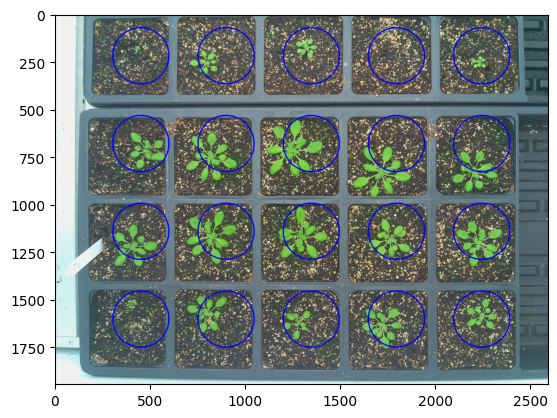

In [11]:
rois = pcv.roi.auto_grid(mask=a_fill, nrows=4, ncols=5, img=img)

# Section 4: Create a labeled mask
In order to measure each plant separately, rather than as one object of disconnected blobs, we must create a labeled masked where each plant has a specific pixel value even in the case of disconnected leaves in the binary mask.



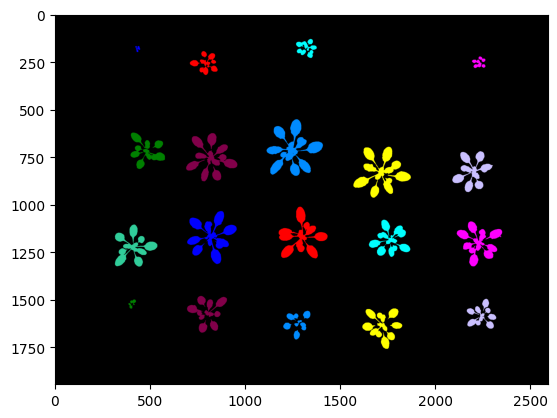

In [12]:
# Create a labeled mask, this function works very similarly to the roi.filter step above
labeled_mask, num_plants = pcv.create_labels(mask=a_fill, rois=rois, roi_type="partial")


# Section 5: Measure each plant


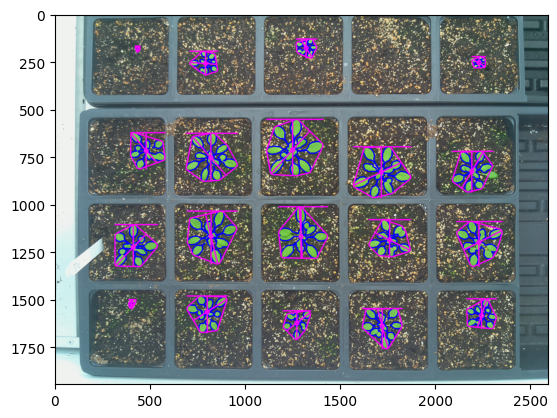

In [13]:
shape_img = pcv.analyze.size(img=img, labeled_mask=labeled_mask, n_labels=20)

In [14]:
shape_img = pcv.analyze.color(rgb_img=img, labeled_mask=labeled_mask, n_labels=20, colorspaces="HSV")

alt.FacetChart(...)

## Save the results

During analysis, measurements are stored in the background in the `outputs` class.

This example includes image analysis for 'area', 'convex_hull_area', 'solidity', 'perimeter', 'width', 'height', 'longest_path', 'center_of_mass, 'convex_hull_vertices', 'object_in_frame', 'ellipse_center', 'ellipse_major_axis', 'ellipse_minor_axis', 'ellipse_angle', 'ellipse_eccentricity' while using `pcv.analyze.size`. Plus we have color trait information also!


In [ ]:
pcv.outputs.save_results(filename=args.result, outformat="csv")